In [1]:
# http://brettromero.com/wordpress/data-science-kaggle-walkthrough-adding-new-data/

In [2]:
import os
os.getcwd()
import numpy as np
import pandas as pd
import pickle
from datetime import datetime, date
from sklearn.preprocessing import LabelEncoder
from sklearn.cross_validation import StratifiedShuffleSplit
from collections import Counter

from matplotlib import pyplot as plt
import plotly.tools as tls
import pandas as pd
import plotly.plotly as py
import plotly.graph_objs as go 
from matplotlib_venn import venn3, venn3_circles
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)
tls.set_credentials_file(username='danielle91515', api_key='bNFnux0jxNwO9rsAJX17')

//anaconda/envs/141b/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [3]:
print('Loading raw data...')
train_users_path='train_users_2.csv'
test_users_path='test_users.csv'
sessions_path='sessions.csv'

Loading raw data...


## Sessions


In [4]:
# sessions
# Change user_id to id
df_sessions = pd.read_csv(sessions_path)
df_sessions['id'] = df_sessions['user_id']
df_sessions = df_sessions.drop(['user_id'],axis=1)
df_sessions.head()

,action,action_type,action_detail,device_type,secs_elapsed,id
0,lookup,NaN,NaN,Windows Desktop,319.0,d1mm9tcy42
1,search_results,click,view_search_results,Windows Desktop,67753.0,d1mm9tcy42
2,lookup,NaN,NaN,Windows Desktop,301.0,d1mm9tcy42
3,search_results,click,view_search_results,Windows Desktop,22141.0,d1mm9tcy42
4,lookup,NaN,NaN,Windows Desktop,435.0,d1mm9tcy42


In [5]:
df_train = pd.read_csv(train_users_path)
target = df_train['country_destination']
#df_train = df_train.drop(['country_destination'], axis=1)
df_test = pd.read_csv(test_users_path)    

## User IDs

In the training dataset, there are 213451 unique user ids;  
In the test dataset, there are 62096 unique user ids;  
In thie sessions dataset, there are 135484 unique user ids;  

71815 (34.58%) users in the training datasets have data in the df_sessions;  
61668 (99.31%) users in the test datasets have data in the df_sessions.

In [6]:
print "The number of user ids in training dataser is %d" %len(df_train)
print "The number of user ids in test dataser is %d" %len(df_test)

The number of user ids in training dataser is 213451
The number of user ids in test dataser is 62096


In [7]:
# This is used to check the duplicates 
#len(Counter(df_test["id"]))
#len(Counter(df_train["id"]))

In [8]:
sessions_id = Counter(df_sessions["id"]).keys()

In [9]:
print len(pd.Series(list(set(df_train["id"]).intersection(set(sessions_id)))))
print len(pd.Series(list(set(df_train["id"]).intersection(set(sessions_id)))))/float(len(df_train["id"]))

73815
0.345817072771


In [10]:
print len(pd.Series(list(set(df_test["id"]).intersection(set(sessions_id)))))
print len(pd.Series(list(set(df_test["id"]).intersection(set(sessions_id)))))/float(len(df_test["id"]))

61668
0.993107446534


In [11]:
len(df_test["id"])

62096

In [12]:
# Intersection of training and testing datasets
print len(pd.Series(list(set(df_train["id"]).intersection(set(df_test["id"])))))

0


In [13]:
# length of unique session ids
len(sessions_id)

135484

In [14]:
# Check intersections of 3 sets
set.intersection(set(df_test["id"]), set(sessions_id), set(df_train["id"]))

set()

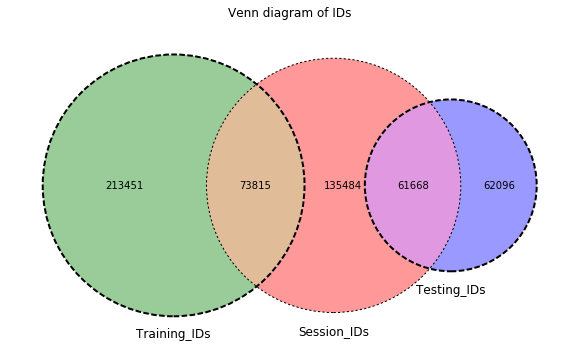

In [15]:
plt.figure(figsize=(10,10))
# Abc, aBc, ABc, abC, AbC, aBC, ABC
v = venn3(subsets=(len(sessions_id), len(Counter(df_train["id"])), len(pd.Series(list(set(df_train["id"]).intersection(set(sessions_id))))), len(Counter(df_test["id"])), len(pd.Series(list(set(df_test["id"]).intersection(set(sessions_id))))), len(pd.Series(list(set(df_train["id"]).intersection(set(df_test["id"]))))), 0), set_labels = ('Session_IDs', 'Training_IDs', 'Testing_IDs'))
c = venn3_circles(subsets=(len(sessions_id), len(Counter(df_train["id"])), len(pd.Series(list(set(df_train["id"]).intersection(set(sessions_id))))), len(Counter(df_test["id"])), len(pd.Series(list(set(df_test["id"]).intersection(set(sessions_id))))), len(pd.Series(list(set(df_train["id"]).intersection(set(df_test["id"]))))), 0), linestyle='dashed')
c[0].set_lw(1.0)
c[0].set_ls('dotted')
plt.title("Venn diagram of IDs")

plt.show()

About **99% users in the test set** have information in the session dataset. Therefore, studying the session dataset carefully is useful to predict the classification of testing ids. Only **34.58% users in the training set** have information in the session dataset.  

## Explore Session Data
Since the training/testing datasets are one user per row, we need to do data aggregation to turn session data into one row per user.

### 1. it is not difficult to imagine that people spending relatively little time to make a booking on a phone are likely to be making bookings in locations closer to home (i.e. the US) than someone spending more time to make a booking on a desktop computer. 

#### a. Explore the relationship between first_device_type in df_train and df_sessions device_type

In [16]:
df_train[df_train["id"] == 'xwxei6hdk4']

,id,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,country_destination
137027,xwxei6hdk4,2014-01-01,20140101002742,2014-01-07,FEMALE,32.0,facebook,0,en,seo,google,linked,Web,iPad,Mobile Safari,US


In [17]:
df_sessions[df_sessions["id"] == 'xwxei6hdk4']

,action,action_type,action_detail,device_type,secs_elapsed,id
315,dashboard,view,dashboard,iPhone,1355.0,xwxei6hdk4
316,header_userpic,data,header_userpic,iPhone,1246.0,xwxei6hdk4
317,NaN,message_post,message_post,iPad Tablet,NaN,xwxei6hdk4
318,ask_question,submit,contact_host,iPad Tablet,386.0,xwxei6hdk4
319,ask_question,submit,contact_host,iPad Tablet,424.0,xwxei6hdk4
320,NaN,message_post,message_post,iPad Tablet,0.0,xwxei6hdk4
321,confirm_email,click,confirm_email_link,iPhone,46262.0,xwxei6hdk4


**We can see that user xwxei6hdk4 uses iphone longer than ipad, even though the first device type is IPAD. Therefore, we first need to correct this information to see whether this can improve the US vs non-US classfications on 71815 training cases **

#### b. Classify US/non-US using original df_train data first_device_type

In [18]:
country_code = [1 if i == 'US' else 0 for i in df_train["country_destination"]]
df_train["country_code"] = country_code  # add country indicator into df_train; if 1 is US 0 is non-us

In [19]:
# Create test sets where users in both training and session datasets
users_insession = pd.Series(list(set(df_train["id"]).intersection(set(sessions_id))))
test = df_train[df_train['id'].isin(list(users_insession))]
test

,id,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,country_destination,country_code
137021,d1mm9tcy42,2014-01-01,20140101000936,2014-01-04,MALE,62.0,basic,0,en,sem-non-brand,google,omg,Web,Windows Desktop,Chrome,other,0
137022,yo8nz8bqcq,2014-01-01,20140101001558,NaN,-unknown-,NaN,basic,0,en,direct,direct,untracked,Web,Mac Desktop,Firefox,NDF,0
137023,4grx6yxeby,2014-01-01,20140101001639,NaN,-unknown-,NaN,basic,0,en,sem-brand,google,omg,Web,Windows Desktop,Firefox,NDF,0
137024,ncf87guaf0,2014-01-01,20140101002146,NaN,-unknown-,NaN,basic,0,en,direct,direct,linked,Web,Windows Desktop,Chrome,NDF,0
137025,4rvqpxoh3h,2014-01-01,20140101002619,2014-01-02,-unknown-,NaN,basic,25,en,direct,direct,untracked,iOS,iPhone,-unknown-,GB,0
137026,c8mfesvkv0,2014-01-01,20140101002626,NaN,-unknown-,NaN,basic,0,en,direct,direct,linked,Web,iPad,Mobile Safari,NDF,0
137027,xwxei6hdk4,2014-01-01,20140101002742,2014-01-07,FEMALE,32.0,facebook,0,en,seo,google,linked,Web,iPad,Mobile Safari,US,1
137028,5f45ro5uzk,2014-01-01,20140101003535,NaN,-unknown-,NaN,basic,0,en,direct,direct,untracked,Web,Windows Desktop,Chrome,NDF,0
137029,ro2stddszp,2014-01-01,20140101005503,2014-12-04,-unknown-,19.0,basic,0,en,sem-brand,google,untracked,Web,Mac Desktop,Safari,other,0
137031,qtw88d9pbl,2014-01-01,20140101005837,NaN,MALE,25.0,basic,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,NDF,0


In [20]:
Counter(test["first_device_type"])

Counter({'Android Phone': 1979,
         'Android Tablet': 701,
         'Desktop (Other)': 489,
         'Mac Desktop': 28029,
         'Other/Unknown': 2993,
         'SmartPhone (Other)': 30,
         'Windows Desktop': 23395,
         'iPad': 5238,
         'iPhone': 10961})

In [21]:
device_code = []
for i in test["first_device_type"]:
    if i == 'Android Phone' or i == 'iPhone' or i == 'SmartPhone (Other)':
        device_code.append(0)
    elif i == 'Android Tablet' or i == 'iPad':
        device_code.append(1)
    elif i == 'Desktop (Other)' or i == 'Mac Desktop' or i == 'Windows Desktop':
        device_code.append(2)
    else:
        device_code.append(3)
test["device_code"] = device_code

/anaconda/envs/141b/lib/python2.7/site-packages/ipykernel/__main__.py:11: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



In [22]:
dest_device = pd.crosstab(test.country_code, test.device_code, margins=True)
dest_device

device_code,0,1,2,3,All
country_code,,,,,
0,10338,4539,36291,2552,53720
1,2632,1400,15622,441,20095
All,12970,5939,51913,2993,73815


In [23]:
list(dest_device.iloc[1,])[:-1]

[2632, 1400, 15622, 441]

In [24]:
trace1 = go.Bar(
    y = ['Phone', 'Tablet', 'Desktop','Other'],
    x = list(dest_device.iloc[1,])[:-1],
    name = 'US',
    orientation = 'h',
    marker = dict(
        color = 'rgba(246, 78, 139, 0.6)',
        line = dict(
            color = 'rgba(246, 78, 139, 1.0)',
            width = 3)
    )
)
trace2 = go.Bar(
    y = ['Phone', 'Tablet', 'Desktop','Other'],
    x = list(dest_device.iloc[0,])[:-1],
    name='Non-US',
    orientation = 'h',
    marker = dict(
        color = 'rgba(58, 71, 80, 0.6)',
        line = dict(
            color = 'rgba(58, 71, 80, 1.0)',
            width = 3)
    )
)

data = [trace1, trace2]
layout = go.Layout(
    barmode='stack',
    #yaxis = list(tickformat = '0.0f')
    xaxis = dict(tickformat = '0.0f')
)

fig = go.Figure(data = data, layout = layout)
py.iplot(fig, filename = 'device vs destination')

#### c. Classify US/non-US using df_sessions data

In [25]:
test_s = df_sessions[df_sessions['id'].isin(list(users_insession))]
test_s

,action,action_type,action_detail,device_type,secs_elapsed,id
0,lookup,NaN,NaN,Windows Desktop,319.0,d1mm9tcy42
1,search_results,click,view_search_results,Windows Desktop,67753.0,d1mm9tcy42
2,lookup,NaN,NaN,Windows Desktop,301.0,d1mm9tcy42
3,search_results,click,view_search_results,Windows Desktop,22141.0,d1mm9tcy42
4,lookup,NaN,NaN,Windows Desktop,435.0,d1mm9tcy42
5,search_results,click,view_search_results,Windows Desktop,7703.0,d1mm9tcy42
6,lookup,NaN,NaN,Windows Desktop,115.0,d1mm9tcy42
7,personalize,data,wishlist_content_update,Windows Desktop,831.0,d1mm9tcy42
8,index,view,view_search_results,Windows Desktop,20842.0,d1mm9tcy42
9,lookup,NaN,NaN,Windows Desktop,683.0,d1mm9tcy42


In [26]:
result = test_s.groupby(["id","device_type"],as_index = False)["secs_elapsed"].agg({'secs_elapsed_total':sum})
result

,id,device_type,secs_elapsed_total
0,00023iyk9l,Mac Desktop,295642.0
1,00023iyk9l,iPhone,572254.0
2,001wyh0pz8,Android App Unknown Phone/Tablet,282965.0
3,0028jgx1x1,-unknown-,297010.0
4,0028jgx1x1,Android Phone,NaN
5,002qnbzfs5,-unknown-,203511.0
6,002qnbzfs5,iPhone,6283569.0
7,0035hobuyj,Mac Desktop,5724670.0
8,00389675gq,Android Phone,236259.0
9,00389675gq,Windows Desktop,2369452.0


In [27]:
result_s = result.sort('secs_elapsed_total', ascending=False).groupby("id", as_index=False).first()
result_s

/anaconda/envs/141b/lib/python2.7/site-packages/ipykernel/__main__.py:1: FutureWarning:

sort(columns=....) is deprecated, use sort_values(by=.....)



,id,device_type,secs_elapsed_total
0,00023iyk9l,iPhone,572254.0
1,001wyh0pz8,Android App Unknown Phone/Tablet,282965.0
2,0028jgx1x1,-unknown-,297010.0
3,002qnbzfs5,iPhone,6283569.0
4,0035hobuyj,Mac Desktop,5724670.0
5,00389675gq,Windows Desktop,2369452.0
6,003iamz20l,iPad Tablet,1590236.0
7,005jc3nbmb,iPhone,1799852.0
8,006mls2sjw,Mac Desktop,2424268.0
9,006t3vhawl,iPad Tablet,815416.0


In [28]:
Counter(result_s["device_type"])

Counter({'-unknown-': 3413,
         'Android App Unknown Phone/Tablet': 2540,
         'Android Phone': 1950,
         'Blackberry': 14,
         'Chromebook': 212,
         'Linux Desktop': 262,
         'Mac Desktop': 26554,
         'Tablet': 655,
         'Windows Desktop': 22206,
         'Windows Phone': 9,
         'iPad Tablet': 5003,
         'iPhone': 10961,
         'iPodtouch': 36})

In [29]:
device_code = []
for i in test["first_device_type"]:
    if i == 'Android Phone' or i == 'iPhone' or i == 'Windows Phone' or i == 'Blackberry' or i == 'iPodtouch':
        device_code.append(0)
    elif i == 'Android Tablet' or i == 'iPad Tablet' or i == 'Tablet':
        device_code.append(1)
    elif i == 'Chromebook' or i == 'Mac Desktop' or i == 'Windows Desktop' or i == 'Linux Desktop':
        device_code.append(2)
    else: # -unknown- or Android App Unknown Phone/Tablet;
        device_code.append(3)
test["device_code_session"] = device_code

/anaconda/envs/141b/lib/python2.7/site-packages/ipykernel/__main__.py:11: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



In [30]:
dest_device = pd.crosstab(test.country_code, test.device_code_session, margins=True)
dest_device

device_code_session,0,1,2,3,All
country_code,,,,,
0,10317,541,35951,6911,53720
1,2623,160,15473,1839,20095
All,12940,701,51424,8750,73815


In [31]:
trace1 = go.Bar(
    y = ['Phone', 'Tablet', 'Desktop','Other'],
    x = list(dest_device.iloc[1,])[:-1],
    name = 'US',
    orientation = 'h',
    marker = dict(
        color = 'rgba(246, 78, 139, 0.6)',
        line = dict(
            color = 'rgba(246, 78, 139, 1.0)',
            width = 3)
    )
)
trace2 = go.Bar(
    y = ['Phone', 'Tablet', 'Desktop','Other'],
    x = list(dest_device.iloc[0,])[:-1],
    name='Non-US',
    orientation = 'h',
    marker = dict(
        color = 'rgba(58, 71, 80, 0.6)',
        line = dict(
            color = 'rgba(58, 71, 80, 1.0)',
            width = 3)
    )
)

data = [trace1, trace2]
layout = go.Layout(
    barmode='stack',
    #yaxis = list(tickformat = '0.0f')
    xaxis = dict(tickformat = '0.0f')
)

fig = go.Figure(data = data, layout = layout)
py.iplot(fig, filename = 'device from session vs destination ')

# 05/27 ####

### Device

### NDF vs. Non-NDF

In [152]:
df_train = pd.read_csv(train_users_path)
df_sessions = pd.read_csv(sessions_path)
df_sessions['id'] = df_sessions['user_id']
df_sessions = df_sessions.drop(['user_id'],axis=1)

users_insession = pd.Series(list(set(df_train["id"]).intersection(set(sessions_id))))
test_s = df_sessions[df_sessions['id'].isin(list(users_insession))]
test = df_train[df_train['id'].isin(list(users_insession))]
result = test_s.groupby(["id","device_type"],as_index = False)["secs_elapsed"].agg({'secs_elapsed_total':sum})
result_s = result.sort('secs_elapsed_total', ascending=False).groupby("id", as_index=False).first()

/anaconda/envs/141b/lib/python2.7/site-packages/ipykernel/__main__.py:10: FutureWarning:

sort(columns=....) is deprecated, use sort_values(by=.....)



In [163]:
test["Primary_Device"] = result_s["device_type"].tolist()

/anaconda/envs/141b/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



In [168]:
Counter(test["first_device_type"])

Counter({'Android Phone': 1979,
         'Android Tablet': 701,
         'Desktop (Other)': 489,
         'Mac Desktop': 28029,
         'Other/Unknown': 2993,
         'SmartPhone (Other)': 30,
         'Windows Desktop': 23395,
         'iPad': 5238,
         'iPhone': 10961})

In [166]:
Counter(test["Primary_Device"])

Counter({'-unknown-': 3413,
         'Android App Unknown Phone/Tablet': 2540,
         'Android Phone': 1950,
         'Blackberry': 14,
         'Chromebook': 212,
         'Linux Desktop': 262,
         'Mac Desktop': 26554,
         'Tablet': 655,
         'Windows Desktop': 22206,
         'Windows Phone': 9,
         'iPad Tablet': 5003,
         'iPhone': 10961,
         'iPodtouch': 36})

In [170]:
device_code = []
for i in test["first_device_type"]:
    if i == 'Android Phone' or i == 'iPhone' or i == 'SmartPhone (Other)':
        device_code.append(0)
    elif i == 'Android Tablet' or i == 'iPad':
        device_code.append(1)
    elif i == 'Desktop (Other)' or i == 'Mac Desktop' or i == 'Windows Desktop':
        device_code.append(2)
    else:
        device_code.append(3)
test["device_code"] = device_code

/anaconda/envs/141b/lib/python2.7/site-packages/ipykernel/__main__.py:11: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



In [169]:
primary_device_code = []

for i in test["Primary_Device"]:
    if i == 'Android Phone' or i == 'iPhone' or i == 'Windows Phone' or i == 'Blackberry' or i == 'iPodtouch':
        primary_device_code.append(0)
    elif i == 'Android Tablet' or i == 'iPad Tablet' or i == 'Tablet':
        primary_device_code.append(1)
    elif i == 'Chromebook' or i == 'Mac Desktop' or i == 'Windows Desktop' or i == 'Linux Desktop':
        primary_device_code.append(2)
    else: # -unknown- or Android App Unknown Phone/Tablet;
        primary_device_code.append(3)
test["device_code_session"] = primary_device_code

/anaconda/envs/141b/lib/python2.7/site-packages/ipykernel/__main__.py:12: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



In [172]:
NDF_status = [1 if i == 'NDF' else 0 for i in test["country_destination"]]
test["NDF_status"] = NDF_status # add NDF indicator into test; if 1 is NDF 0 is non-NDF

/anaconda/envs/141b/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



In [174]:
test.head()

,id,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,country_destination,Primary_Device,device_code_session,device_code,NDF_status
137021,d1mm9tcy42,2014-01-01,20140101000936,2014-01-04,MALE,62.0,basic,0,en,sem-non-brand,google,omg,Web,Windows Desktop,Chrome,other,iPhone,0,2,0
137022,yo8nz8bqcq,2014-01-01,20140101001558,NaN,-unknown-,NaN,basic,0,en,direct,direct,untracked,Web,Mac Desktop,Firefox,NDF,Android App Unknown Phone/Tablet,3,2,1
137023,4grx6yxeby,2014-01-01,20140101001639,NaN,-unknown-,NaN,basic,0,en,sem-brand,google,omg,Web,Windows Desktop,Firefox,NDF,-unknown-,3,2,1
137024,ncf87guaf0,2014-01-01,20140101002146,NaN,-unknown-,NaN,basic,0,en,direct,direct,linked,Web,Windows Desktop,Chrome,NDF,iPhone,0,2,1
137025,4rvqpxoh3h,2014-01-01,20140101002619,2014-01-02,-unknown-,NaN,basic,25,en,direct,direct,untracked,iOS,iPhone,-unknown-,GB,Mac Desktop,2,0,0


#### a. NDF/NON-NDF First_Device_Type

In [245]:
# 'Phone', 'Tablet', 'Desktop','Other'
ndf_device = pd.crosstab(test.NDF_status, test.device_code, margins=True)
ndf_device.columns = pd.Index(['Phone', 'Tablet', 'Desktop','Other','All'], name="First_device")
ndf_device

First_device,Phone,Tablet,Desktop,Other,All
NDF_status,,,,,
0,3416,2142,22615,601,28774
1,9554,3797,29298,2392,45041
All,12970,5939,51913,2993,73815


In [361]:
ndf_device_pct = pd.crosstab(test.NDF_status, test.device_code, margins=True).iloc[:,:4].apply(lambda r: r/r.sum(), axis=1)
ndf_device_pct.columns = pd.Index(['Phone', 'Tablet', 'Desktop','Other'], name="First_device_percent")
ndf_device_pct*100

First_device_percent,Phone,Tablet,Desktop,Other
NDF_status,,,,
0,11.871829,7.444220,78.595260,2.088691
1,21.211785,8.430097,65.047401,5.310717
All,17.570954,8.045790,70.328524,4.054731


In [367]:
ndf_device_pct_1 = pd.crosstab(test.NDF_status, test.device_code, margins=True).iloc[:2,:].apply(lambda r: r/r.sum(), axis=0)*100
ndf_device_pct_1 .columns = pd.Index(['Phone', 'Tablet', 'Desktop','Other','All'], name="First_device_percent")
ndf_device_pct_1 

First_device_percent,Phone,Tablet,Desktop,Other,All
NDF_status,,,,,
0,26.337702,36.066678,43.563269,20.080187,38.981237
1,73.662298,63.933322,56.436731,79.919813,61.018763


In [178]:
trace1 = go.Bar(
    x = ['Non-NDF','NDF'],
    y = list(ndf_device.iloc[:,2])[:-1],
    text = [str(round(i * 100,2)) + '%' for i in ndf_device_pct.iloc[:,2][:-1]],
    name = 'Desktop',
    #orientation = 'h',
    marker = dict(
        color = '#fff0f7',
        line = dict(
            color = 'rgba(58, 71, 80, 1.0)',
            width = 1.5)
    )
)
trace2 = go.Bar(
    x = ['Non-NDF','NDF'],
    y = list(ndf_device.iloc[:,1])[:-1],
    text = [str(round(i * 100,2)) + '%' for i in ndf_device_pct.iloc[:,1][:-1]],
    name='Tablet',
    #orientation = 'h',
    marker = dict(
        color = '#ffc0cb',
        line = dict(
            color = 'rgba(58, 71, 80, 1.0)',
            width = 1.5)
    )
)
trace3 = go.Bar(
    x = ['Non-NDF','NDF'],
    y = list(ndf_device.iloc[:,0])[:-1],
    text = [str(round(i * 100,2)) + '%' for i in ndf_device_pct.iloc[:,0][:-1]],
    name = 'Phone',
    #orientation = 'h',
    marker = dict(
        color = '#ff69b4',
        line = dict(
            color = 'rgba(58, 71, 80, 1.0)',
            width = 1.5)
    )
)
trace4 = go.Bar(
    x = ['Non-NDF','NDF'],
    y = list(ndf_device.iloc[:,3])[:-1],
    text = [str(round(i * 100,2)) + '%' for i in ndf_device_pct.iloc[:,3][:-1]],
    name='Other',
    #orientation = 'h',
    marker = dict(
        color = '#red',
        line = dict(
            color = 'rgba(58, 71, 80, 1.0)',
            width = 1.5)
    )
)

data = [trace1, trace2, trace3, trace4]
layout = go.Layout(
    barmode='group',
    #yaxis = list(tickformat = '0.0f')
    yaxis = dict(tickformat = '0.0f')
)

fig = go.Figure(data = data, layout = layout)
py.iplot(fig, filename = 'NDF vs Non-NDF First Device Type')

#### b. NDF/NON-NDF Primary_Device_Type

In [247]:
# 'Phone', 'Tablet', 'Desktop','Other'
ndf_device_s = pd.crosstab(test.NDF_status, test.device_code_session, margins=True)
ndf_device_s.columns = pd.Index(['Phone', 'Tablet', 'Desktop','Other','All'], name="Primary_device")
ndf_device_s

Primary_device,Phone,Tablet,Desktop,Other,All
NDF_status,,,,,
0,5126,2238,19066,2344,28774
1,7844,3420,30168,3609,45041
All,12970,5658,49234,5953,73815


In [239]:
ndf_device_s.shape

(3, 5)

In [368]:
ndf_device_pct_s = pd.crosstab(test.NDF_status, test.device_code_session, margins=True).iloc[:,:4].apply(lambda r: r/r.sum(), axis=1)
ndf_device_pct_s.columns = pd.Index(['Phone', 'Tablet', 'Desktop','Other'], name="Primary_device_percentage")
ndf_device_pct_s*100

Primary_device_percentage,Phone,Tablet,Desktop,Other
NDF_status,,,,
0,17.814694,7.777855,66.261208,8.146243
1,17.415244,7.593082,66.978975,8.012700
All,17.570954,7.665109,66.699180,8.064756


In [370]:
ndf_device_pct_s_1 = pd.crosstab(test.NDF_status, test.device_code_session, margins=True).iloc[:2,:].apply(lambda r: r/r.sum(), axis=0)
ndf_device_pct_s_1.columns = pd.Index(['Phone', 'Tablet', 'Desktop','Other','All'], name="Primary_device_percentage")
ndf_device_pct_s_1*100

Primary_device_percentage,Phone,Tablet,Desktop,Other,All
NDF_status,,,,,
0,39.521974,39.554613,38.725271,39.375105,38.981237
1,60.478026,60.445387,61.274729,60.624895,61.018763


In [183]:
trace1 = go.Bar(
    x = ['Non-NDF','NDF'],
    y = list(ndf_device_s.iloc[:,2])[:-1],
    text = [str(round(i * 100,2)) + '%' for i in ndf_device_pct_s.iloc[:,2][:-1]],
    name = 'Desktop',
    #orientation = 'h',
    marker = dict(
        color = '#fff0f7',
        line = dict(
            color = 'rgba(58, 71, 80, 1.0)',
            width = 1.5)
    )
)
trace2 = go.Bar(
    x = ['Non-NDF','NDF'],
    y = list(ndf_device_s.iloc[:,1])[:-1],
    text = [str(round(i * 100,2)) + '%' for i in ndf_device_pct_s.iloc[:,1][:-1]],
    name='Tablet',
    #orientation = 'h',
    marker = dict(
        color = '#ffc0cb',
        line = dict(
            color = 'rgba(58, 71, 80, 1.0)',
            width = 1.5)
    )
)
trace3 = go.Bar(
    x = ['Non-NDF','NDF'],
    y = list(ndf_device_s.iloc[:,0])[:-1],
    text = [str(round(i * 100,2)) + '%' for i in ndf_device_pct_s.iloc[:,0][:-1]],
    name = 'Phone',
    #orientation = 'h',
    marker = dict(
        color = '#ff69b4',
        line = dict(
            color = 'rgba(58, 71, 80, 1.0)',
            width = 1.5)
    )
)
trace4 = go.Bar(
    x = ['Non-NDF','NDF'],
    y = list(ndf_device_s.iloc[:,3])[:-1],
    text = [str(round(i * 100,2)) + '%' for i in ndf_device_pct_s.iloc[:,3][:-1]],
    name='Other',
    #orientation = 'h',
    marker = dict(
        color = '#red',
        line = dict(
            color = 'rgba(58, 71, 80, 1.0)',
            width = 1.5)
    )
)

data = [trace1, trace2, trace3, trace4]
layout = go.Layout(
    barmode='group',
    #yaxis = list(tickformat = '0.0f')
    yaxis = dict(tickformat = '0.0f')
)

fig = go.Figure(data = data, layout = layout)
py.iplot(fig, filename = 'NDF vs Non-NDF Primary Device Type')

#### Summary Device Type vs NDF Status

In [251]:
ndf_device_pct*100

First_device_percent,Phone,Tablet,Desktop,Other
NDF_status,,,,
0,11.871829,7.444220,78.595260,2.088691
1,21.211785,8.430097,65.047401,5.310717
All,17.570954,8.045790,70.328524,4.054731


In [250]:
ndf_device_pct_s*100

Primary_device_percentage,Phone,Tablet,Desktop,Other
NDF_status,,,,
0,17.814694,7.777855,66.261208,8.146243
1,17.415244,7.593082,66.978975,8.012700
All,17.570954,7.665109,66.699180,8.064756


#### specific device table for first device

In [301]:
pd.crosstab(test.first_device_type, test.NDF_status, margins=True).iloc[:,:2]

NDF_status,0,1
first_device_type,,
Android Phone,460,1519
Android Tablet,246,455
Desktop (Other),212,277
Mac Desktop,12803,15226
Other/Unknown,601,2392
SmartPhone (Other),9,21
Windows Desktop,9600,13795
iPad,1896,3342
iPhone,2947,8014


In [371]:
a = pd.crosstab(test.first_device_type, test.NDF_status, margins=True).iloc[:-1,:2].apply(lambda r: r/r.sum(), axis=1)
a

NDF_status,0,1
first_device_type,,
Android Phone,0.232441,0.767559
Android Tablet,0.350927,0.649073
Desktop (Other),0.433538,0.566462
Mac Desktop,0.456777,0.543223
Other/Unknown,0.200802,0.799198
SmartPhone (Other),0.300000,0.700000
Windows Desktop,0.410344,0.589656
iPad,0.361970,0.638030
iPhone,0.268862,0.731138


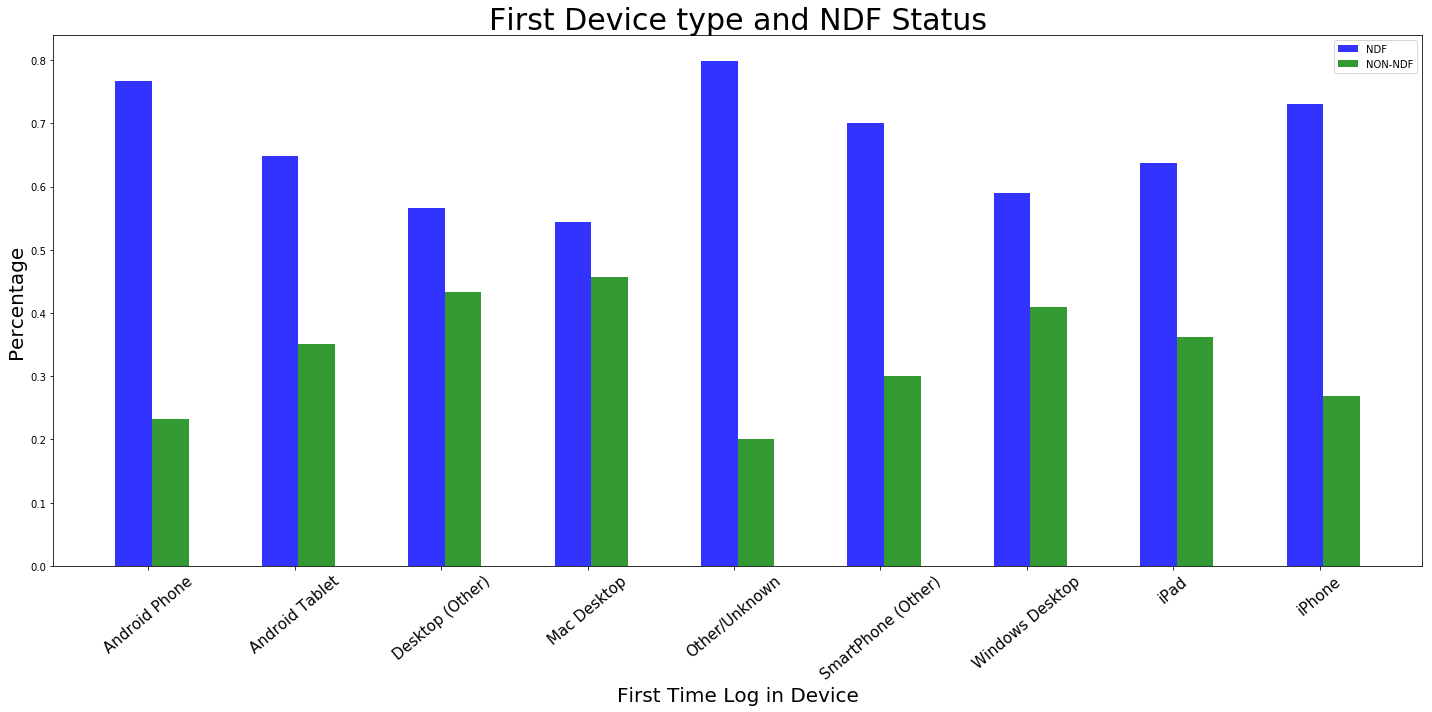

In [373]:
# data to plot
n_groups = len(a.index.values.tolist())
means_ndf = a.iloc[:,1]
means_nonndf = a.iloc[:,0]
 
# create plot
fig, ax = plt.subplots(figsize=(20, 10))
index = np.arange(n_groups)
bar_width = 0.25
opacity = 0.8
 
rects1 = plt.bar(index, means_ndf, bar_width,
                 alpha= opacity,
                 color='b',
                 label='NDF')
 
rects2 = plt.bar(index + bar_width, means_nonndf, bar_width,
                 alpha=opacity,
                 color='g',
                 label='NON-NDF')
 
plt.xlabel('First Time Log in Device', fontsize = 20)
plt.ylabel('Percentage', fontsize = 20)
plt.title('First Device type and NDF Status',fontsize = 30)
plt.xticks(index+0.1, a.index.values.tolist(),rotation=40,fontsize =15)
plt.legend()
 
plt.tight_layout()
plt.show()

#### specific device table for primary device

In [258]:
pd.crosstab(test.Primary_Device, test.NDF_status, margins=True).iloc[:,:2]

NDF_status,0,1
Primary_Device,,
-unknown-,1342,2071
Android App Unknown Phone/Tablet,1002,1538
Android Phone,794,1156
Blackberry,4,10
Chromebook,84,128
Linux Desktop,110,152
Mac Desktop,10382,16172
Tablet,257,398
Windows Desktop,8490,13716


In [374]:
a = pd.crosstab(test.Primary_Device, test.NDF_status, margins=True).iloc[:-1,:2].apply(lambda r: r/r.sum(), axis=1)

In [375]:
a

NDF_status,0,1
Primary_Device,,
-unknown-,0.393202,0.606798
Android App Unknown Phone/Tablet,0.394488,0.605512
Android Phone,0.407179,0.592821
Blackberry,0.285714,0.714286
Chromebook,0.396226,0.603774
Linux Desktop,0.419847,0.580153
Mac Desktop,0.390977,0.609023
Tablet,0.392366,0.607634
Windows Desktop,0.382329,0.617671


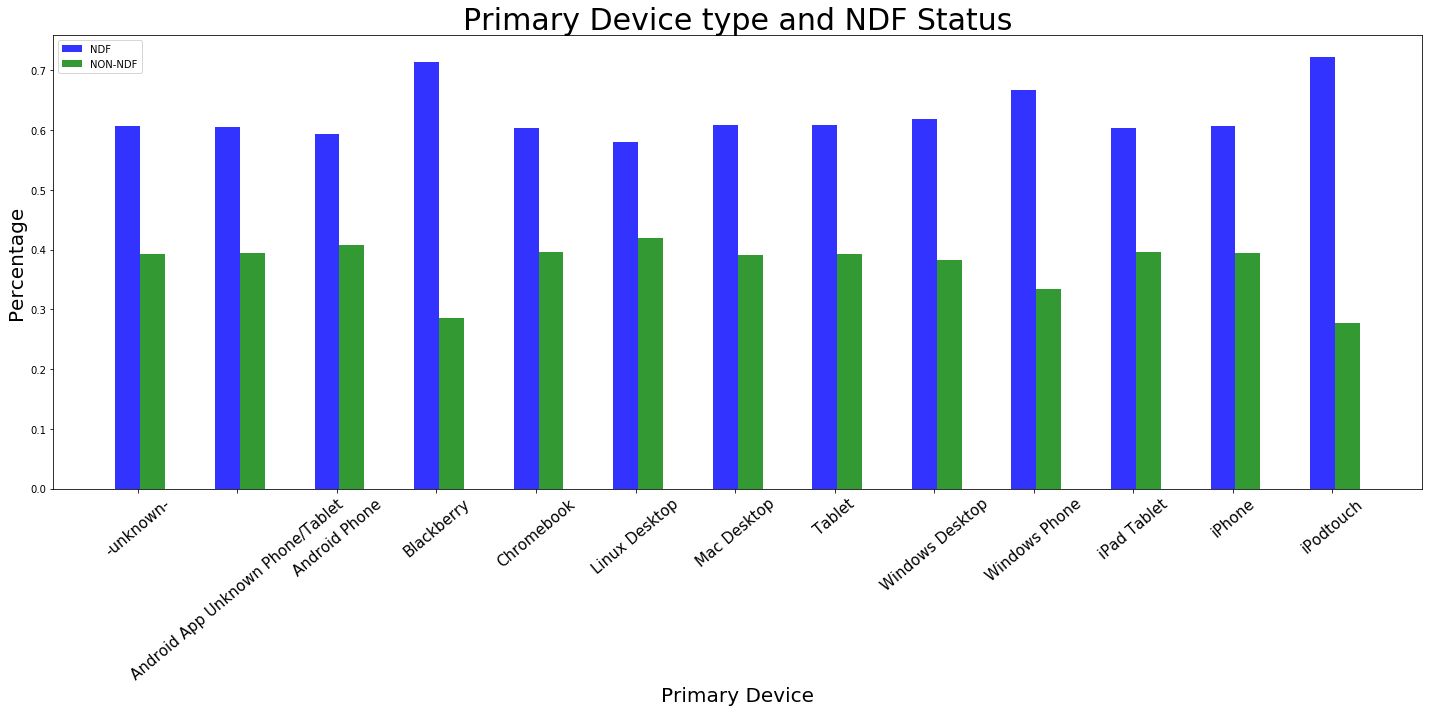

In [376]:
# data to plot
n_groups = len(a.index.values.tolist())
means_ndf = a.iloc[:,1]
means_nonndf = a.iloc[:,0]
 
# create plot
fig, ax = plt.subplots(figsize=(20, 10))
index = np.arange(n_groups)
bar_width = 0.25
opacity = 0.8
 
rects1 = plt.bar(index, means_ndf, bar_width,
                 alpha=opacity,
                 color='b',
                 label='NDF')
 
rects2 = plt.bar(index + bar_width, means_nonndf, bar_width,
                 alpha=opacity,
                 color='g',
                 label='NON-NDF')
 
plt.xlabel('Primary Device', fontsize = 20)
plt.ylabel('Percentage', fontsize = 20)
plt.title('Primary Device type and NDF Status',fontsize = 30)
plt.xticks(index+0.1, a.index.values.tolist(),rotation=40,fontsize =15)
plt.legend()
 
plt.tight_layout()
plt.show()

### US VS NONUS within NON - NDF

In [306]:
nonndf = test[test["country_destination"] != 'NDF']
country_code = [1 if i == 'US' else 0 for i in nonndf["country_destination"]]
nonndf["country_code"] = country_code  # add country indicator into df_train; if 1 is US 0 is non-us

/anaconda/envs/141b/lib/python2.7/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



In [307]:
nonndf.head()

,id,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,...,first_affiliate_tracked,signup_app,first_device_type,first_browser,country_destination,Primary_Device,device_code_session,device_code,NDF_status,country_code
137021,d1mm9tcy42,2014-01-01,20140101000936,2014-01-04,MALE,62.0,basic,0,en,sem-non-brand,...,omg,Web,Windows Desktop,Chrome,other,iPhone,0,2,0,0
137025,4rvqpxoh3h,2014-01-01,20140101002619,2014-01-02,-unknown-,NaN,basic,25,en,direct,...,untracked,iOS,iPhone,-unknown-,GB,Mac Desktop,2,0,0,0
137027,xwxei6hdk4,2014-01-01,20140101002742,2014-01-07,FEMALE,32.0,facebook,0,en,seo,...,linked,Web,iPad,Mobile Safari,US,iPad Tablet,1,1,0,1
137029,ro2stddszp,2014-01-01,20140101005503,2014-12-04,-unknown-,19.0,basic,0,en,sem-brand,...,untracked,Web,Mac Desktop,Safari,other,Mac Desktop,2,2,0,0
137032,awiurksqr3,2014-01-01,20140101010113,2014-01-02,FEMALE,32.0,facebook,0,en,direct,...,untracked,Web,iPad,Mobile Safari,US,Android Phone,0,1,0,1


#### a. US/NON-US  First_Device_Type

In [343]:
us_device = pd.crosstab(nonndf.country_code, nonndf.device_code, margins=True)
us_device.columns = pd.Index(['Phone', 'Tablet', 'Desktop','Other','All'], name="First_device")
us_device

First_device,Phone,Tablet,Desktop,Other,All
country_code,,,,,
0,784,742,6993,160,8679
1,2632,1400,15622,441,20095
All,3416,2142,22615,601,28774


In [377]:
us_device_pct = pd.crosstab(nonndf.country_code, nonndf.device_code, margins=True).iloc[:,:4].apply(lambda r: r/r.sum(), axis=1)
us_device_pct.columns = pd.Index(['Phone', 'Tablet', 'Desktop','Other'], name="First_device_pct")
us_device_pct*100

First_device_pct,Phone,Tablet,Desktop,Other
country_code,,,,
0,9.033299,8.549372,80.573799,1.843530
1,13.097786,6.966907,77.740732,2.194576
All,11.871829,7.444220,78.595260,2.088691


In [378]:
us_device_pct_1 = pd.crosstab(nonndf.country_code, nonndf.device_code, margins=True).iloc[:2,:].apply(lambda r: r/r.sum(), axis=0)
us_device_pct_1.columns = pd.Index(['Phone', 'Tablet', 'Desktop','Other','All'], name="First_device_pct")
us_device_pct_1*100

First_device_pct,Phone,Tablet,Desktop,Other,All
country_code,,,,,
0,22.95082,34.640523,30.921954,26.622296,30.162647
1,77.04918,65.359477,69.078046,73.377704,69.837353


In [312]:
trace1 = go.Bar(
    x = ['Non-US','US'],
    y = list(us_device.iloc[:,2])[:-1],
    text = [str(round(i * 100,2)) + '%' for i in us_device_pct.iloc[:,2][:-1]],
    name = 'Desktop',
    #orientation = 'h',
    marker = dict(
        color = '#fff0f7',
        line = dict(
            color = 'rgba(58, 71, 80, 1.0)',
            width = 1)
    )
)
trace2 = go.Bar(
    x = ['Non-US','US'],
    y = list(us_device.iloc[:,1])[:-1],
    text = [str(round(i * 100,2)) + '%' for i in us_device_pct.iloc[:,1][:-1]],
    name='Tablet',
    #orientation = 'h',
    marker = dict(
        color = '#ffc0cb',
        line = dict(
            color = 'rgba(58, 71, 80, 1.0)',
            width = 1)
    )
)
trace3 = go.Bar(
    x = ['Non-US','US'],
    y = list(us_device.iloc[:,0])[:-1],
    text = [str(round(i * 100,2)) + '%' for i in us_device_pct.iloc[:,0][:-1]],
    name = 'Phone',
    #orientation = 'h',
    marker = dict(
        color = '#ff69b4',
        line = dict(
            color = 'rgba(58, 71, 80, 1.0)',
            width = 1)
    )
)
trace4 = go.Bar(
    x = ['Non-US','US'],
    y = list(us_device.iloc[:,3])[:-1],
    text = [str(round(i * 100,2)) + '%' for i in us_device_pct.iloc[:,3][:-1]],
    name='Other',
    #orientation = 'h',
    marker = dict(
        color = '#red',
        line = dict(
            color = 'rgba(58, 71, 80, 1.0)',
            width = 1)
    )
)

data = [trace1, trace2, trace3, trace4]
layout = go.Layout(
    barmode='group',
    #yaxis = list(tickformat = '0.0f')
    yaxis = dict(tickformat = '0.0f')
)

fig = go.Figure(data = data, layout = layout)
py.iplot(fig, filename = 'US vs Non-US in NON-NDF First Device')

In [380]:
us_device_s = pd.crosstab(nonndf.country_code, nonndf.device_code_session, margins=True)
us_device_s.columns = pd.Index(['Phone', 'Tablet', 'Desktop','Other','All'], name="Primary_device")
us_device_s

Primary_device,Phone,Tablet,Desktop,Other,All
country_code,,,,,
0,1554,684,5760,681,8679
1,3572,1554,13306,1663,20095
All,5126,2238,19066,2344,28774


In [381]:
us_device_pct_s = pd.crosstab(nonndf.country_code, nonndf.device_code_session, margins=True).iloc[:,:4].apply(lambda r: r/r.sum(), axis=1)
us_device_pct_s.columns = pd.Index(['Phone', 'Tablet', 'Desktop','Other'], name="Primary_device_pct")
us_device_pct_s*100

Primary_device_pct,Phone,Tablet,Desktop,Other
country_code,,,,
0,17.905289,7.881092,66.367093,7.846526
1,17.775566,7.733267,66.215476,8.275690
All,17.814694,7.777855,66.261208,8.146243


In [382]:
us_device_pct_s_1 = pd.crosstab(nonndf.country_code, nonndf.device_code_session, margins=True).iloc[:2,:].apply(lambda r: r/r.sum(), axis=0)
us_device_pct_s_1.columns = pd.Index(['Phone', 'Tablet', 'Desktop','Other','All'], name="Primary_device_pct")
us_device_pct_s_1*100

Primary_device_pct,Phone,Tablet,Desktop,Other,All
country_code,,,,,
0,30.316036,30.563003,30.210847,29.052901,30.162647
1,69.683964,69.436997,69.789153,70.947099,69.837353


In [315]:
trace1 = go.Bar(
    x = ['Non-US','US'],
    y = list(us_device_s.iloc[:,2])[:-1],
    text = [str(round(i * 100,2)) + '%' for i in us_device_pct_s.iloc[:,2][:-1]],
    name = 'Desktop',
    #orientation = 'h',
    marker = dict(
        color = '#fff0f7',
        line = dict(
            color = 'rgba(58, 71, 80, 1.0)',
            width = 1)
    )
)
trace2 = go.Bar(
    x = ['Non-US','US'],
    y = list(us_device_s.iloc[:,1])[:-1],
    text = [str(round(i * 100,2)) + '%' for i in us_device_pct_s.iloc[:,1][:-1]],
    name='Tablet',
    #orientation = 'h',
    marker = dict(
        color = '#ffc0cb',
        line = dict(
            color = 'rgba(58, 71, 80, 1.0)',
            width = 1)
    )
)
trace3 = go.Bar(
    x = ['Non-US','US'],
    y = list(us_device_s.iloc[:,0])[:-1],
    text = [str(round(i * 100,2)) + '%' for i in us_device_pct_s.iloc[:,0][:-1]],
    name = 'Phone',
    #orientation = 'h',
    marker = dict(
        color = '#ff69b4',
        line = dict(
            color = 'rgba(58, 71, 80, 1.0)',
            width = 1)
    )
)
trace4 = go.Bar(
    x = ['Non-US','US'],
    y = list(us_device_s.iloc[:,3])[:-1],
    text = [str(round(i * 100,2)) + '%' for i in us_device_pct_s.iloc[:,3][:-1]],
    name='Other',
    #orientation = 'h',
    marker = dict(
        color = '#red',
        line = dict(
            color = 'rgba(58, 71, 80, 1.0)',
            width = 1)
    )
)

data = [trace1, trace2, trace3, trace4]
layout = go.Layout(
    barmode='group',
    #yaxis = list(tickformat = '0.0f')
    yaxis = dict(tickformat = '0.0f')
)

fig = go.Figure(data = data, layout = layout)
py.iplot(fig, filename = 'US vs Non-US in NON-NDF Primary Device')

#### Summary

In [349]:
us_device_pct*100

First_device_pct,Phone,Tablet,Desktop,Other
country_code,,,,
0,9.033299,8.549372,80.573799,1.843530
1,13.097786,6.966907,77.740732,2.194576
All,11.871829,7.444220,78.595260,2.088691


In [350]:
us_device_pct_s*100

First_device_pct,Phone,Tablet,Desktop,Other
country_code,,,,
0,17.905289,7.881092,66.367093,7.846526
1,17.775566,7.733267,66.215476,8.275690
All,17.814694,7.777855,66.261208,8.146243


#### specific device table for first device

In [329]:
pd.crosstab(nonndf.first_device_type, nonndf.country_code, margins=True)

country_code,0,1,All
first_device_type,,,
Android Phone,87,373,460
Android Tablet,86,160,246
Desktop (Other),63,149,212
Mac Desktop,3970,8833,12803
Other/Unknown,160,441,601
SmartPhone (Other),0,9,9
Windows Desktop,2960,6640,9600
iPad,656,1240,1896
iPhone,697,2250,2947


In [383]:
a = pd.crosstab(nonndf.first_device_type, nonndf.country_code, margins=True).iloc[:-1,:2].apply(lambda r: r/r.sum(), axis=1)
a

country_code,0,1
first_device_type,,
Android Phone,0.189130,0.810870
Android Tablet,0.349593,0.650407
Desktop (Other),0.297170,0.702830
Mac Desktop,0.310084,0.689916
Other/Unknown,0.266223,0.733777
SmartPhone (Other),0.000000,1.000000
Windows Desktop,0.308333,0.691667
iPad,0.345992,0.654008
iPhone,0.236512,0.763488


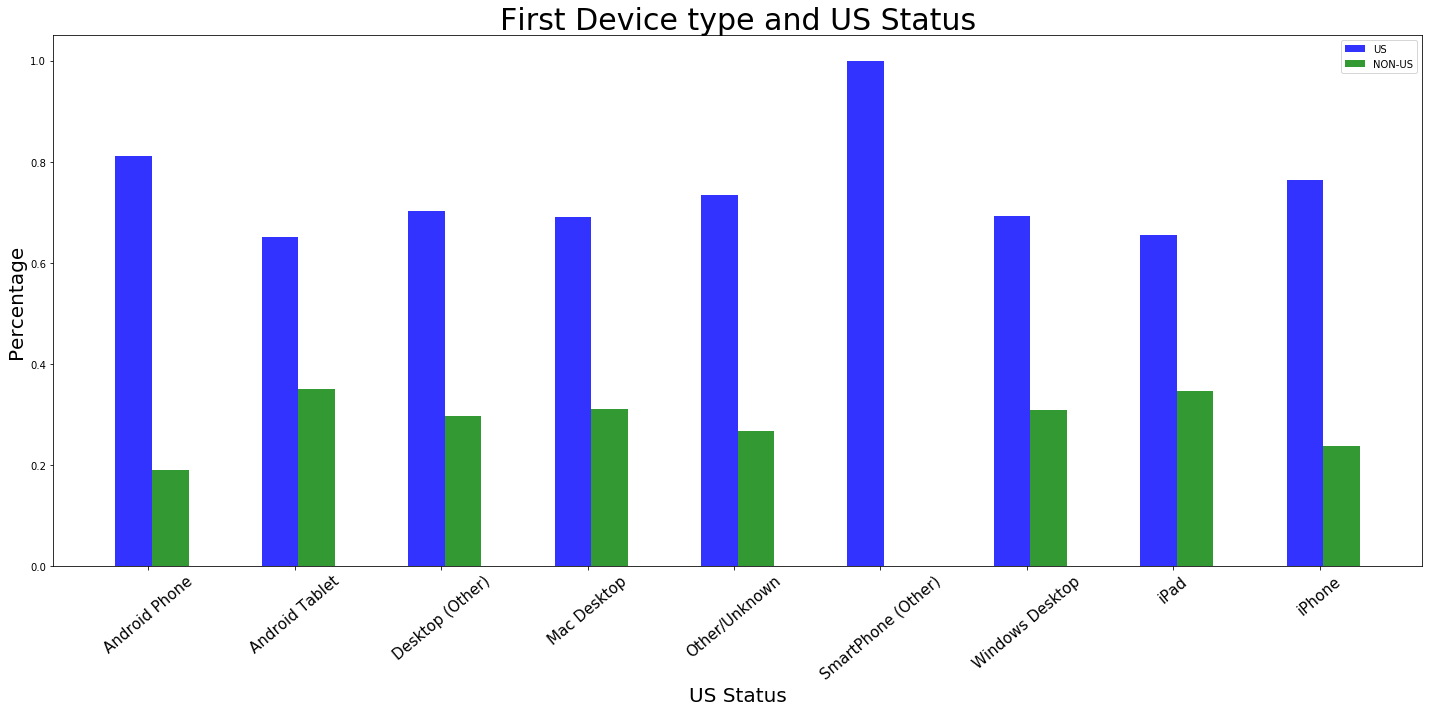

In [384]:
# data to plot
n_groups = len(a.index.values.tolist())
means_us = a.iloc[:,1]
means_nonus = a.iloc[:,0]
 
# create plot
fig, ax = plt.subplots(figsize=(20, 10))
index = np.arange(n_groups)
bar_width = 0.25
opacity = 0.8
 
rects1 = plt.bar(index, means_us, bar_width,
                 alpha=opacity,
                 color='b',
                 label='US')
 
rects2 = plt.bar(index + bar_width, means_nonus, bar_width,
                 alpha=opacity,
                 color='g',
                 label='NON-US')
 
plt.xlabel('US Status', fontsize = 20)
plt.ylabel('Percentage', fontsize = 20)
plt.title('First Device type and US Status',fontsize = 30)
plt.xticks(index+0.1, a.index.values.tolist(),rotation=40,fontsize =15)
plt.legend()
 
plt.tight_layout()
plt.show()

#### specific device table for primary device

In [333]:
pd.crosstab(nonndf.Primary_Device, nonndf.country_code, margins=True).iloc[:,:2]

country_code,0,1
Primary_Device,,
-unknown-,380,962
Android App Unknown Phone/Tablet,301,701
Android Phone,269,525
Blackberry,0,4
Chromebook,25,59
Linux Desktop,38,72
Mac Desktop,3160,7222
Tablet,77,180
Windows Desktop,2537,5953


In [385]:
a = pd.crosstab(nonndf.Primary_Device, nonndf.country_code, margins=True).iloc[:-1,:2].apply(lambda r: r/r.sum(), axis=1)
a

country_code,0,1
Primary_Device,,
-unknown-,0.283159,0.716841
Android App Unknown Phone/Tablet,0.300399,0.699601
Android Phone,0.338791,0.661209
Blackberry,0.000000,1.000000
Chromebook,0.297619,0.702381
Linux Desktop,0.345455,0.654545
Mac Desktop,0.304373,0.695627
Tablet,0.299611,0.700389
Windows Desktop,0.298822,0.701178


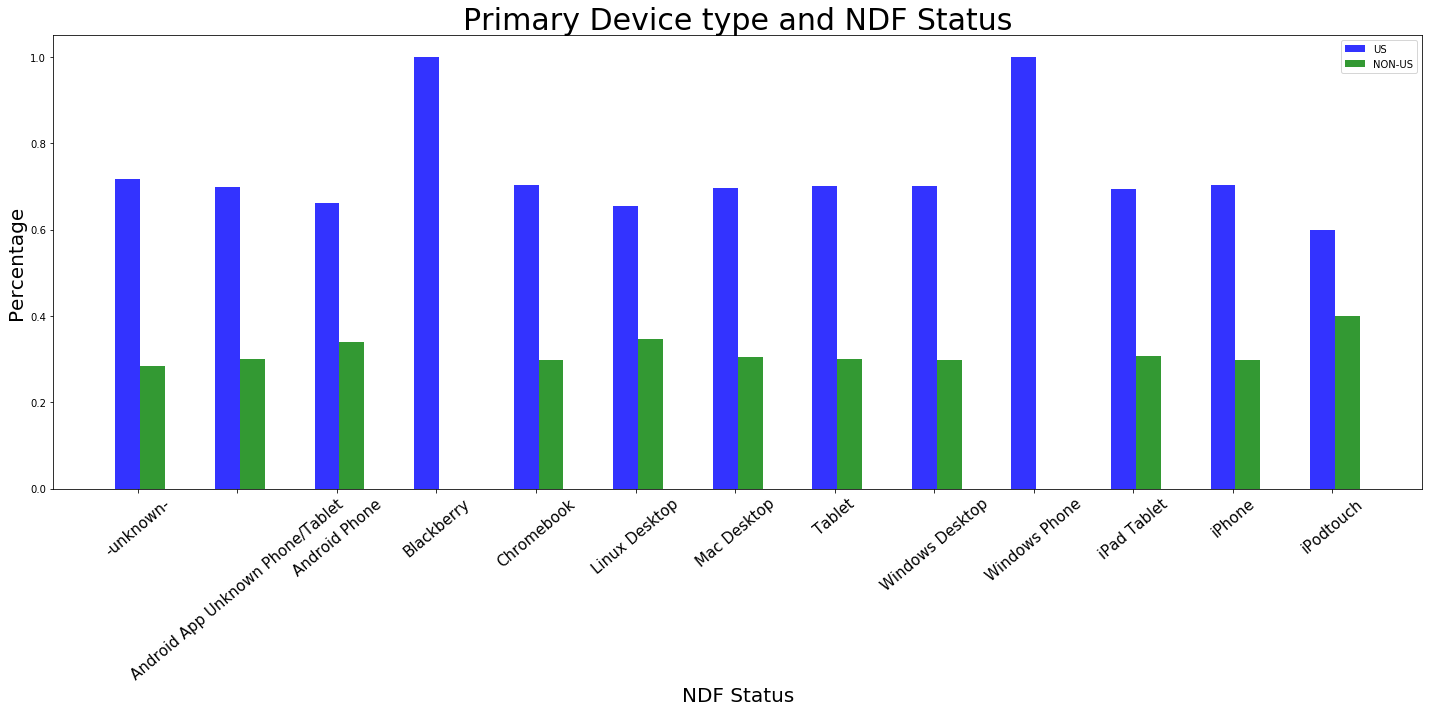

In [386]:
# data to plot
n_groups = len(a.index.values.tolist())
means_us = a.iloc[:,1]
means_nonus = a.iloc[:,0]
 
# create plot
fig, ax = plt.subplots(figsize=(20, 10))
index = np.arange(n_groups)
bar_width = 0.25
opacity = 0.8
 
rects1 = plt.bar(index, means_us, bar_width,
                 alpha=opacity,
                 color='b',
                 label='US')
 
rects2 = plt.bar(index + bar_width, means_nonus, bar_width,
                 alpha=opacity,
                 color='g',
                 label='NON-US')
 
plt.xlabel('NDF Status', fontsize = 20)
plt.ylabel('Percentage', fontsize = 20)
plt.title('Primary Device type and NDF Status',fontsize = 30)
plt.xticks(index+0.1, a.index.values.tolist(),rotation=40,fontsize =15)
plt.legend()
 
plt.tight_layout()
plt.show()

### NON-us other counties

In [336]:
nonus = nonndf[nonndf["country_destination"] != 'US']

In [337]:
nonus.head()

,id,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,...,first_affiliate_tracked,signup_app,first_device_type,first_browser,country_destination,Primary_Device,device_code_session,device_code,NDF_status,country_code
137021,d1mm9tcy42,2014-01-01,20140101000936,2014-01-04,MALE,62.0,basic,0,en,sem-non-brand,...,omg,Web,Windows Desktop,Chrome,other,iPhone,0,2,0,0
137025,4rvqpxoh3h,2014-01-01,20140101002619,2014-01-02,-unknown-,NaN,basic,25,en,direct,...,untracked,iOS,iPhone,-unknown-,GB,Mac Desktop,2,0,0,0
137029,ro2stddszp,2014-01-01,20140101005503,2014-12-04,-unknown-,19.0,basic,0,en,sem-brand,...,untracked,Web,Mac Desktop,Safari,other,Mac Desktop,2,2,0,0
137033,ucgks2fyez,2014-01-01,20140101010900,2014-12-18,-unknown-,76.0,basic,0,en,seo,...,untracked,Web,iPad,Mobile Safari,other,Windows Desktop,2,1,0,0
137036,jrqykh9y8x,2014-01-01,20140101011919,2014-04-19,FEMALE,27.0,facebook,0,zh,seo,...,linked,Web,Mac Desktop,Chrome,FR,-unknown-,3,2,0,0


In [338]:
nonus["country_destination"].unique()

array(['other', 'GB', 'FR', 'IT', 'CA', 'AU', 'DE', 'ES', 'NL', 'PT'], dtype=object)

In [339]:
Other_country_code = []
for i in nonus["country_destination"]:
    if i == 'other':
        Other_country_code.append(1)
    elif i == 'GB':
        Other_country_code.append(2)
    elif i == 'FR':
        Other_country_code.append(3)
    elif i == 'IT':
        Other_country_code.append(4)
    elif i == 'CA':
        Other_country_code.append(5)
    elif i == 'AU':
        Other_country_code.append(6)
    elif i == 'DE':
        Other_country_code.append(7)
    elif i == 'ES':
        Other_country_code.append(8)
    elif i == 'NL':
        Other_country_code.append(9)
    elif i == 'PT':
        Other_country_code.append(10)
nonus["Other_country_code"] = Other_country_code

/anaconda/envs/141b/lib/python2.7/site-packages/ipykernel/__main__.py:23: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



In [340]:
nonus.head()

,id,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,...,signup_app,first_device_type,first_browser,country_destination,Primary_Device,device_code_session,device_code,NDF_status,country_code,Other_country_code
137021,d1mm9tcy42,2014-01-01,20140101000936,2014-01-04,MALE,62.0,basic,0,en,sem-non-brand,...,Web,Windows Desktop,Chrome,other,iPhone,0,2,0,0,1
137025,4rvqpxoh3h,2014-01-01,20140101002619,2014-01-02,-unknown-,NaN,basic,25,en,direct,...,iOS,iPhone,-unknown-,GB,Mac Desktop,2,0,0,0,2
137029,ro2stddszp,2014-01-01,20140101005503,2014-12-04,-unknown-,19.0,basic,0,en,sem-brand,...,Web,Mac Desktop,Safari,other,Mac Desktop,2,2,0,0,1
137033,ucgks2fyez,2014-01-01,20140101010900,2014-12-18,-unknown-,76.0,basic,0,en,seo,...,Web,iPad,Mobile Safari,other,Windows Desktop,2,1,0,0,1
137036,jrqykh9y8x,2014-01-01,20140101011919,2014-04-19,FEMALE,27.0,facebook,0,zh,seo,...,Web,Mac Desktop,Chrome,FR,-unknown-,3,2,0,0,3


#### First Device US

In [390]:
nonus_device = pd.crosstab(nonus.Other_country_code, nonus.device_code, margins=True)
nonus_device.columns = pd.Index(['Phone', 'Tablet', 'Desktop','Other','All'], name="First_device")
nonus_device.index = pd.Index(['other', 'GB', 'FR', 'IT', 'CA', 'AU', 'DE', 'ES', 'NL', 'PT','All'])
nonus_device

First_device,Phone,Tablet,Desktop,Other,All
other,385,299,2873,98,3655
GB,61,69,593,8,731
FR,111,127,1178,19,1435
IT,78,84,807,10,979
CA,33,30,371,6,440
AU,13,17,120,2,152
DE,15,22,209,4,250
ES,63,65,569,10,707
NL,20,22,203,2,247
PT,5,7,70,1,83


In [391]:
nonus_device_pct = pd.crosstab(nonus.Other_country_code, nonus.device_code, margins=True).iloc[:,:4].apply(lambda r: r/r.sum(), axis=1)
nonus_device_pct.columns = pd.Index(['Phone', 'Tablet', 'Desktop','Other'], name="First_device_pct")
nonus_device_pct.index = pd.Index(['other', 'GB', 'FR', 'IT', 'CA', 'AU', 'DE', 'ES', 'NL', 'PT','All'])
nonus_device_pct*100

First_device_pct,Phone,Tablet,Desktop,Other
other,10.533516,8.180575,78.604651,2.681259
GB,8.344733,9.439124,81.121751,1.094391
FR,7.735192,8.850174,82.090592,1.324042
IT,7.967314,8.580184,82.431052,1.021450
CA,7.500000,6.818182,84.318182,1.363636
AU,8.552632,11.184211,78.947368,1.315789
DE,6.000000,8.800000,83.600000,1.600000
ES,8.910891,9.193777,80.480905,1.414427
NL,8.097166,8.906883,82.186235,0.809717
PT,6.024096,8.433735,84.337349,1.204819


In [393]:
nonus_device_pct_1 = pd.crosstab(nonus.Other_country_code, nonus.device_code, margins=True).iloc[:10,:].apply(lambda r: r/r.sum(), axis=0)
nonus_device_pct_1.columns = pd.Index(['Phone', 'Tablet', 'Desktop','Other','All'], name="First_device_pct")
nonus_device_pct_1.index = pd.Index(['other', 'GB', 'FR', 'IT', 'CA', 'AU', 'DE', 'ES', 'NL', 'PT'])
nonus_device_pct_1*100

First_device_pct,Phone,Tablet,Desktop,Other,All
other,49.107143,40.296496,41.083941,61.250,42.113147
GB,7.780612,9.299191,8.479908,5.000,8.422629
FR,14.158163,17.115903,16.845417,11.875,16.534163
IT,9.948980,11.320755,11.540112,6.250,11.280101
CA,4.209184,4.043127,5.305305,3.750,5.069708
AU,1.658163,2.291105,1.716002,1.250,1.751354
DE,1.913265,2.964960,2.988703,2.500,2.880516
ES,8.035714,8.760108,8.136708,6.250,8.146100
NL,2.551020,2.964960,2.902903,1.250,2.845950
PT,0.637755,0.943396,1.001001,0.625,0.956331


In [394]:
trace1 = go.Bar(
    x = ['other', 'GB', 'FR', 'IT', 'CA', 'AU', 'DE', 'ES', 'NL', 'PT'],
    y = list(nonus_device.iloc[:,2])[0:10],
    text = [str(round(i * 100,2)) + '%' for i in list(nonus_device_pct.iloc[:,2])[0:10]],
    name='Desktop',
    #orientation = 'h',
    marker = dict(
        color = '#fff0f7',
        line = dict(
            color = 'rgba(58, 71, 80, 1.0)',
            width = 1)
    )
)
trace2 = go.Bar(
    x = ['other', 'GB', 'FR', 'IT', 'CA', 'AU', 'DE', 'ES', 'NL', 'PT'],
    y = list(nonus_device.iloc[:,3])[0:10],
    text = [str(round(i * 100,2)) + '%' for i in list(nonus_device_pct.iloc[:,3])[0:10]],
    name='Other',
    #orientation = 'h',
    marker = dict(
        color = '#ffc0cb',
        line = dict(
            color = 'rgba(58, 71, 80, 1.0)',
            width = 1)
    )
)

trace3 = go.Bar(
    x = ['other', 'GB', 'FR', 'IT', 'CA', 'AU', 'DE', 'ES', 'NL', 'PT'],
    y = list(nonus_device.iloc[:,0])[0:10],
    text = [str(round(i * 100,2)) + '%' for i in list(nonus_device_pct.iloc[:,0])[0:10]],
    name = 'Phone',
    #orientation = 'h',
    marker = dict(
        color = '#ff69b4',
        line = dict(
            color = 'rgba(246, 78, 139, 1.0)',
            width = 1)
    )
)
trace4 = go.Bar(
    x = ['other', 'GB', 'FR', 'IT', 'CA', 'AU', 'DE', 'ES', 'NL', 'PT'],
    y = list(nonus_device.iloc[:,1])[0:10],
    text = [str(round(i * 100,2)) + '%' for i in list(nonus_device_pct.iloc[:,1])[0:10]],
    name='Tablet',
    #orientation = 'h',
    marker = dict(
        color = '#red',
        line = dict(
            color = 'rgba(58, 71, 80, 1.0)',
            width = 1
        )
    )
)

data = [trace1, trace2, trace3, trace4]
layout = go.Layout(
    barmode='stack',
    #yaxis = list(tickformat = '0.0f')
    yaxis = dict(tickformat = '0.0f')
)

fig = go.Figure(data = data, layout = layout)
py.iplot(fig, filename = 'First Devices for NON-US')

#### Primary Device US

In [400]:
nonus_device_s = pd.crosstab(nonus.Other_country_code, nonus.device_code_session, margins=True)
nonus_device_s.columns = pd.Index(['Phone', 'Tablet', 'Desktop','Other','All'], name="Primary_device")
nonus_device_s.index = pd.Index(['other', 'GB', 'FR', 'IT', 'CA', 'AU', 'DE', 'ES', 'NL', 'PT','All'])
nonus_device_s

Primary_device,Phone,Tablet,Desktop,Other,All
other,686,264,2423,282,3655
GB,137,51,483,60,731
FR,234,119,961,121,1435
IT,174,86,635,84,979
CA,63,37,308,32,440
AU,28,15,95,14,152
DE,45,22,161,22,250
ES,127,58,477,45,707
NL,45,22,162,18,247
PT,15,10,55,3,83


In [401]:
nonus_device_pct_s = pd.crosstab(nonus.Other_country_code, nonus.device_code_session, margins=True).iloc[:,:4].apply(lambda r: r/r.sum(), axis=1)
nonus_device_pct_s.columns = pd.Index(['Phone', 'Tablet', 'Desktop','Other'], name="Primary_device_pct")
nonus_device_pct_s.index = pd.Index(['other', 'GB', 'FR', 'IT', 'CA', 'AU', 'DE', 'ES', 'NL', 'PT','All'])
nonus_device_pct_s*100

Primary_device_pct,Phone,Tablet,Desktop,Other
other,18.768810,7.222982,66.292750,7.715458
GB,18.741450,6.976744,66.073871,8.207934
FR,16.306620,8.292683,66.968641,8.432056
IT,17.773238,8.784474,64.862104,8.580184
CA,14.318182,8.409091,70.000000,7.272727
AU,18.421053,9.868421,62.500000,9.210526
DE,18.000000,8.800000,64.400000,8.800000
ES,17.963225,8.203678,67.468175,6.364922
NL,18.218623,8.906883,65.587045,7.287449
PT,18.072289,12.048193,66.265060,3.614458


In [402]:
nonus_device_pct_s_1 = pd.crosstab(nonus.Other_country_code, nonus.device_code_session, margins=True).iloc[:10,:].apply(lambda r: r/r.sum(), axis=0)
nonus_device_pct_s_1.columns = pd.Index(['Phone', 'Tablet', 'Desktop','Other','All'], name="Primary_device_pct")
nonus_device_pct_s_1.index = pd.Index(['other', 'GB', 'FR', 'IT', 'CA', 'AU', 'DE', 'ES', 'NL', 'PT'])
nonus_device_pct_s_1*100

Primary_device_pct,Phone,Tablet,Desktop,Other,All
other,44.144144,38.596491,42.065972,41.409692,42.113147
GB,8.815959,7.456140,8.385417,8.810573,8.422629
FR,15.057915,17.397661,16.684028,17.767988,16.534163
IT,11.196911,12.573099,11.024306,12.334802,11.280101
CA,4.054054,5.409357,5.347222,4.698972,5.069708
AU,1.801802,2.192982,1.649306,2.055800,1.751354
DE,2.895753,3.216374,2.795139,3.230543,2.880516
ES,8.172458,8.479532,8.281250,6.607930,8.146100
NL,2.895753,3.216374,2.812500,2.643172,2.845950
PT,0.965251,1.461988,0.954861,0.440529,0.956331


In [395]:
trace1 = go.Bar(
    x = ['other', 'GB', 'FR', 'IT', 'CA', 'AU', 'DE', 'ES', 'NL', 'PT'],
    y = list(nonus_device_s.iloc[:,2])[0:10],
    text = [str(round(i * 100,2)) + '%' for i in list(nonus_device_pct_s.iloc[:,2])[0:10]],
    name='Desktop',
    #orientation = 'h',
    marker = dict(
        color = '#fff0f7',
        line = dict(
            color = 'rgba(58, 71, 80, 1.0)',
            width = 1)
    )
)
trace2 = go.Bar(
    x = ['other', 'GB', 'FR', 'IT', 'CA', 'AU', 'DE', 'ES', 'NL', 'PT'],
    y = list(nonus_device_s.iloc[:,3])[0:10],
    text = [str(round(i * 100,2)) + '%' for i in list(nonus_device_pct_s.iloc[:,3])[0:10]],
    name='Other',
    #orientation = 'h',
    marker = dict(
        color = '#ffc0cb',
        line = dict(
            color = 'rgba(58, 71, 80, 1.0)',
            width = 1)
    )
)

trace3 = go.Bar(
    x = ['other', 'GB', 'FR', 'IT', 'CA', 'AU', 'DE', 'ES', 'NL', 'PT'],
    y = list(nonus_device_s.iloc[:,0])[0:10],
    text = [str(round(i * 100,2)) + '%' for i in list(nonus_device_pct_s.iloc[:,0])[0:10]],
    name = 'Phone',
    #orientation = 'h',
    marker = dict(
        color = '#ff69b4',
        line = dict(
            color = 'rgba(246, 78, 139, 1.0)',
            width = 1)
    )
)
trace4 = go.Bar(
    x = ['other', 'GB', 'FR', 'IT', 'CA', 'AU', 'DE', 'ES', 'NL', 'PT'],
    y = list(nonus_device_s.iloc[:,1])[0:10],
    text = [str(round(i * 100,2)) + '%' for i in list(nonus_device_pct_s.iloc[:,1])[0:10]],
    name='Tablet',
    #orientation = 'h',
    marker = dict(
        color = '#red',
        line = dict(
            color = 'rgba(58, 71, 80, 1.0)',
            width = 1
        )
    )
)

data = [trace1, trace2, trace3, trace4]
layout = go.Layout(
    barmode='stack',
    #yaxis = list(tickformat = '0.0f')
    yaxis = dict(tickformat = '0.0f')
)

fig = go.Figure(data = data, layout = layout)
py.iplot(fig, filename = 'Primary Devices for NON-US')

# Session

In [445]:
test_s = df_sessions[df_sessions['id'].isin(list(users_insession))]
test_s # intersection of training and session id which has training

,action,action_type,action_detail,device_type,secs_elapsed,id
0,lookup,NaN,NaN,Windows Desktop,319.0,d1mm9tcy42
1,search_results,click,view_search_results,Windows Desktop,67753.0,d1mm9tcy42
2,lookup,NaN,NaN,Windows Desktop,301.0,d1mm9tcy42
3,search_results,click,view_search_results,Windows Desktop,22141.0,d1mm9tcy42
4,lookup,NaN,NaN,Windows Desktop,435.0,d1mm9tcy42
5,search_results,click,view_search_results,Windows Desktop,7703.0,d1mm9tcy42
6,lookup,NaN,NaN,Windows Desktop,115.0,d1mm9tcy42
7,personalize,data,wishlist_content_update,Windows Desktop,831.0,d1mm9tcy42
8,index,view,view_search_results,Windows Desktop,20842.0,d1mm9tcy42
9,lookup,NaN,NaN,Windows Desktop,683.0,d1mm9tcy42


#### 1. Change nan to NAN

In [446]:
test_s.action = test_s.action.fillna('NAN')
test_s.action_type = test_s.action_type.fillna('NAN')
test_s.action_detail = test_s.action_detail.fillna('NAN')
test_s.device_type = test_s.device_type.fillna('NAN')

In [440]:
test_s["action"].value_counts()

show                                            1301904
index                                            463093
personalize                                      449753
search_results                                   419689
ajax_refresh_subtotal                            315766
similar_listings                                 307947
search                                           206834
update                                           206115
social_connections                               145365
lookup                                           136212
reviews                                           99999
active                                            85166
header_userpic                                    84877
create                                            84866
dashboard                                         74060
track_page_view                                   63338
collections                                       61016
edit                                            

#### 2. Combine all actions < 100 to others

In [428]:
# Action values with low frequency are changed to 'OTHER'
act_freq = 100  #Threshold for frequency
act = dict(zip(*np.unique(test_s.action, return_counts=True)))
test_s.action = test_s.action.apply(lambda x: 'OTHER' if act[x] < act_freq else x)

In [448]:
#test_s = df_sessions[df_sessions['id'].isin(list(users_insession))]
result = test_s.groupby(["id"],as_index = False)["secs_elapsed"].agg({'secs_elapsed_total':'sum'})
result

,id,secs_elapsed_total
0,00023iyk9l,867896.0
1,001wyh0pz8,282965.0
2,0028jgx1x1,297010.0
3,002qnbzfs5,6487080.0
4,0035hobuyj,5724670.0
5,00389675gq,2605711.0
6,003iamz20l,1590236.0
7,005jc3nbmb,2793945.0
8,006mls2sjw,2424268.0
9,006t3vhawl,815416.0


In [449]:
result_mean = test_s.groupby(["id"],as_index = False)["secs_elapsed"].agg({'secs_elapsed_mean':'mean'})
result_mean
#result_s_mean = result.sort('secs_elapsed_total', ascending=False).groupby("id", as_index=False).first()

,id,secs_elapsed_mean
0,00023iyk9l,22253.743590
1,001wyh0pz8,3179.382022
2,0028jgx1x1,9900.333333
3,002qnbzfs5,8232.335025
4,0035hobuyj,11730.881148
5,00389675gq,14805.176136
6,003iamz20l,9816.271605
7,005jc3nbmb,111757.800000
8,006mls2sjw,12496.226804
9,006t3vhawl,31362.153846


In [461]:
test["secs_elapsed_total"] = result["secs_elapsed_total"].tolist()
test["secs_elapsed_mean"] = result_mean["secs_elapsed_mean"].tolist()

/anaconda/envs/141b/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/anaconda/envs/141b/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



In [464]:
test.groupby(["country_destination"],as_index = False)["secs_elapsed_total"].agg({'mean_secs_elapsed_total':'mean'})

,country_destination,mean_secs_elapsed_total
0,AU,1.309988e+06
1,CA,1.434780e+06
2,DE,1.638397e+06
3,ES,1.532455e+06
4,FR,1.491211e+06
5,GB,1.619440e+06
6,IT,1.615440e+06
7,NDF,1.534865e+06
8,NL,1.588434e+06
9,PT,1.388019e+06


In [469]:
test.groupby(["country_destination"],as_index = False)["secs_elapsed_mean"].agg({'mean_secs_elapsed_mean':'mean'})

,country_destination,mean_secs_elapsed_mean
0,AU,30791.848861
1,CA,29283.018935
2,DE,31845.862654
3,ES,29881.371796
4,FR,29337.281331
5,GB,35030.631862
6,IT,35260.184746
7,NDF,32595.924856
8,NL,36964.000013
9,PT,49070.936348


In [471]:
test.groupby(["NDF_status"],as_index = False)["secs_elapsed_total"].agg({'mean_secs_elapsed_total':'mean'})

,NDF_status,mean_secs_elapsed_total
0,0,1.545270e+06
1,1,1.534865e+06


In [472]:
test.groupby(["NDF_status"],as_index = False)["secs_elapsed_mean"].agg({'mean_secs_elapsed_mean':'mean'})

,NDF_status,mean_secs_elapsed_mean
0,0,32764.861994
1,1,32595.924856


#### non-ndf us nonus

In [478]:
nonndf_1 = test[test["country_destination"] != 'NDF']
country_code = [1 if i == 'US' else 0 for i in nonndf_1["country_destination"]]
nonndf_1["country_code"] = country_code  # add country indicator into df_train; if 1 is US 0 is non-us
nonndf_1.head()

/anaconda/envs/141b/lib/python2.7/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



,id,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,...,first_device_type,first_browser,country_destination,Primary_Device,device_code_session,device_code,NDF_status,secs_elapsed_total,secs_elapsed_mean,country_code
137021,d1mm9tcy42,2014-01-01,20140101000936,2014-01-04,MALE,62.0,basic,0,en,sem-non-brand,...,Windows Desktop,Chrome,other,iPhone,0,2,0,867896.0,22253.743590,0
137025,4rvqpxoh3h,2014-01-01,20140101002619,2014-01-02,-unknown-,NaN,basic,25,en,direct,...,iPhone,-unknown-,GB,Mac Desktop,2,0,0,5724670.0,11730.881148,0
137027,xwxei6hdk4,2014-01-01,20140101002742,2014-01-07,FEMALE,32.0,facebook,0,en,seo,...,iPad,Mobile Safari,US,iPad Tablet,1,1,0,1590236.0,9816.271605,1
137029,ro2stddszp,2014-01-01,20140101005503,2014-12-04,-unknown-,19.0,basic,0,en,sem-brand,...,Mac Desktop,Safari,other,Mac Desktop,2,2,0,2424268.0,12496.226804,0
137032,awiurksqr3,2014-01-01,20140101010113,2014-01-02,FEMALE,32.0,facebook,0,en,direct,...,iPad,Mobile Safari,US,Android Phone,0,1,0,324222.0,27018.500000,1


In [479]:
nonndf_1.groupby(["country_code"],as_index = False)["secs_elapsed_total"].agg({'mean_secs_elapsed_total':'mean'})

,country_code,mean_secs_elapsed_total
0,0,1.539482e+06
1,1,1.547774e+06


In [480]:
nonndf_1.groupby(["country_code"],as_index = False)["secs_elapsed_mean"].agg({'mean_secs_elapsed_mean':'mean'})

,country_code,mean_secs_elapsed_mean
0,0,32633.560388
1,1,32821.643043


#### non-us

In [481]:
nonus_1 = nonndf_1[nonndf_1["country_destination"] != 'US']

In [483]:
nonus_1

,id,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,...,first_device_type,first_browser,country_destination,Primary_Device,device_code_session,device_code,NDF_status,secs_elapsed_total,secs_elapsed_mean,country_code
137021,d1mm9tcy42,2014-01-01,20140101000936,2014-01-04,MALE,62.0,basic,0,en,sem-non-brand,...,Windows Desktop,Chrome,other,iPhone,0,2,0,867896.0,22253.743590,0
137025,4rvqpxoh3h,2014-01-01,20140101002619,2014-01-02,-unknown-,NaN,basic,25,en,direct,...,iPhone,-unknown-,GB,Mac Desktop,2,0,0,5724670.0,11730.881148,0
137029,ro2stddszp,2014-01-01,20140101005503,2014-12-04,-unknown-,19.0,basic,0,en,sem-brand,...,Mac Desktop,Safari,other,Mac Desktop,2,2,0,2424268.0,12496.226804,0
137033,ucgks2fyez,2014-01-01,20140101010900,2014-12-18,-unknown-,76.0,basic,0,en,seo,...,iPad,Mobile Safari,other,Windows Desktop,2,1,0,370406.0,46300.750000,0
137036,jrqykh9y8x,2014-01-01,20140101011919,2014-04-19,FEMALE,27.0,facebook,0,zh,seo,...,Mac Desktop,Chrome,FR,-unknown-,3,2,0,NaN,NaN,0
137041,11581i5wng,2014-01-01,20140101020334,2014-03-19,-unknown-,NaN,basic,0,en,direct,...,Mac Desktop,Chrome,FR,iPhone,0,2,0,375194.0,93798.500000,0
137053,nmptg2k3tj,2014-01-01,20140101033422,2014-01-01,-unknown-,NaN,basic,0,en,direct,...,Windows Desktop,Chrome,FR,Linux Desktop,2,2,0,3227.0,3227.000000,0
137075,stiseqi6h6,2014-01-01,20140101075428,2014-04-11,-unknown-,NaN,basic,0,en,direct,...,Windows Desktop,Firefox,IT,Android App Unknown Phone/Tablet,3,2,0,82274.0,8227.400000,0
137076,d6r5a2l398,2014-01-01,20140101081440,2014-03-12,MALE,25.0,facebook,12,en,api,...,Other/Unknown,-unknown-,other,iPhone,0,3,0,242990.0,10124.583333,0
137079,2pw9yjm8aq,2014-01-01,20140101091423,2014-01-01,-unknown-,NaN,basic,0,en,seo,...,Windows Desktop,Chrome,other,iPhone,0,2,0,6197114.0,18893.640244,0


In [484]:
nonus_1.groupby(["country_destination"],as_index = False)["secs_elapsed_total"].agg({'mean_secs_elapsed_total':'mean'})

,country_destination,mean_secs_elapsed_total
0,AU,1.309988e+06
1,CA,1.434780e+06
2,DE,1.638397e+06
3,ES,1.532455e+06
4,FR,1.491211e+06
5,GB,1.619440e+06
6,IT,1.615440e+06
7,NL,1.588434e+06
8,PT,1.388019e+06
9,other,1.539362e+06


In [486]:
nonus_1.groupby(["country_destination"],as_index = False)["secs_elapsed_mean"].agg({'mean_secs_elapsed_mean':'mean'})

,country_destination,mean_secs_elapsed_mean
0,AU,30791.848861
1,CA,29283.018935
2,DE,31845.862654
3,ES,29881.371796
4,FR,29337.281331
5,GB,35030.631862
6,IT,35260.184746
7,NL,36964.000013
8,PT,49070.936348
9,other,33142.730949


In [494]:
Counter(df_train["first_browser"])

Counter({'-unknown-': 27266,
         'AOL Explorer': 245,
         'Android Browser': 851,
         'Apple Mail': 36,
         'Arora': 1,
         'Avant Browser': 4,
         'BlackBerry Browser': 53,
         'Camino': 9,
         'Chrome': 63845,
         'Chrome Mobile': 1270,
         'Chromium': 73,
         'CometBird': 11,
         'Comodo Dragon': 2,
         'Conkeror': 1,
         'CoolNovo': 6,
         'Crazy Browser': 2,
         'Epic': 1,
         'Firefox': 33655,
         'Flock': 2,
         'Google Earth': 1,
         'Googlebot': 1,
         'IE': 21068,
         'IE Mobile': 36,
         'IceDragon': 1,
         'IceWeasel': 13,
         'Iron': 17,
         'Kindle Browser': 1,
         'Maxthon': 46,
         'Mobile Firefox': 30,
         'Mobile Safari': 19274,
         'Mozilla': 3,
         'NetNewsWire': 1,
         'OmniWeb': 2,
         'Opera': 188,
         'Opera Mini': 4,
         'Opera Mobile': 2,
         'Outlook 2007': 1,
         'PS Vita brow

In [495]:
df_sessions.head()

,action,action_type,action_detail,device_type,secs_elapsed,id
0,lookup,NaN,NaN,Windows Desktop,319.0,d1mm9tcy42
1,search_results,click,view_search_results,Windows Desktop,67753.0,d1mm9tcy42
2,lookup,NaN,NaN,Windows Desktop,301.0,d1mm9tcy42
3,search_results,click,view_search_results,Windows Desktop,22141.0,d1mm9tcy42
4,lookup,NaN,NaN,Windows Desktop,435.0,d1mm9tcy42


In [497]:
nonndf.shape

(28774, 21)

In [498]:
test.shape

(73815, 22)

In [500]:
nonus.shape

(8679, 22)

In [502]:
Counter(nonus["country_destination"])

Counter({'AU': 152,
         'CA': 440,
         'DE': 250,
         'ES': 707,
         'FR': 1435,
         'GB': 731,
         'IT': 979,
         'NL': 247,
         'PT': 83,
         'other': 3655})

In [503]:
Counter(df_train["country_destination"])

Counter({'AU': 539,
         'CA': 1428,
         'DE': 1061,
         'ES': 2249,
         'FR': 5023,
         'GB': 2324,
         'IT': 2835,
         'NDF': 124543,
         'NL': 762,
         'PT': 217,
         'US': 62376,
         'other': 10094})

In [505]:
df_train.shape

(213451, 16)

In [513]:
62376/float(213451)

0.2922263189209702

In [515]:
20095/float(73815)

0.2722346406556933